# OpenStreetMap Data Wrangling with MongoDB

## Project Overview
To choose any area of the world in https://www.openstreetmap.org and use data wrangling techniques, such as assessing the quality of the data for validity, accuracy, completeness, consistency and uniformity, to clean the OpenStreetMap data for that part of the world. Finally, use MongoDB as the data schema to complete your project by storing, querying and aggregating the data.

### OSM Dataset
The data area selected for this project is of the "old" Toronto area of Ontario, Canada. This area was choosen primiarly because I currently live in the city of Toronto but specifically within the "old" Toronto area and not the "new" or "Greater Toronto Area" aka the GTA, which is much larger. I would like to work with more mapping/local type datasets to learn and help educate others about data-based facts related to your local area. This would be a great start towards that.

Data was directly exported from OpenStreetMap and Overpass-API:
- https://www.openstreetmap.org/relation/2989349#map=12/43.6789/-79.3851
- http://overpass-api.de/api/map?bbox=-79.5455,43.6015,-79.2262,43.7458

### Old Toronto

- https://en.wikipedia.org/wiki/Old_Toronto

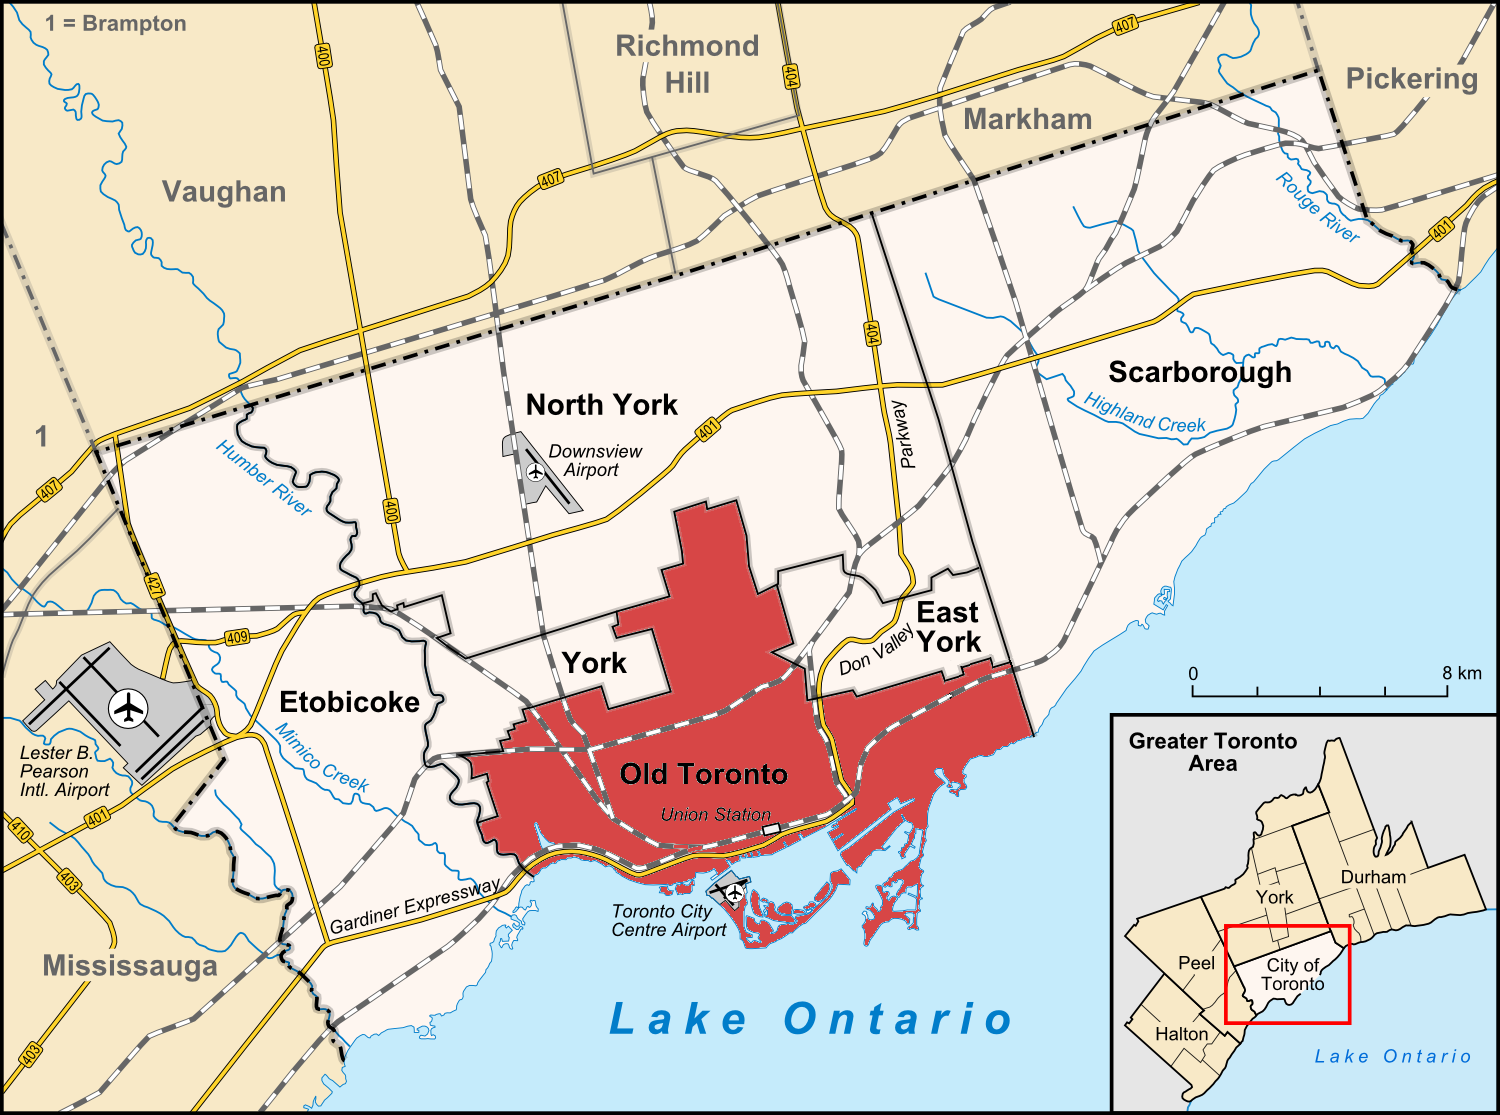

In [1]:
from IPython.display import Image
Image("https://upload.wikimedia.org/wikipedia/commons/a/a6/Old_Toronto_locator.png", width ="600")

## Data Audit

### Issues
Prior to working with the entire dataset an initially review/investigation of a sample set of the data was performed. I noticed three main problems with the sample data. Each data problem will be highlighted below.

- Abbreviated street names (St. for Street)
- Ambiguous abbreviation (St. for Street vs St. for Saint)
- Multiple abbreviations in values (Queen St E instead of Queen Street East)
- Incorrect and inconsistent postal codes (format)

**Street Names**

Although the data didn't suggest a large problem with street names, there were quite a few abbrievation issues that I didn't think of prior to the investigation.

- Robertoway - to - "Roberto Way"
- StreetE - to - "Street East"
- AvenueE - to - "Avenue East"
- Queen St E - to - "Queen Street East"

However, each problem was identified and fixed. The expected entries such as St vs St. were also found but it St. for Saint was initially a problem, particular knowing that complex combinations could still be valid, such as...

**St. Clarie St. E** ( Saint Claire Street East, but "Saint" is not typically spelt out in address names )

**Postal Codes**

Toronto, similar to all other cities in Canada have a strongly formatted/structured postal (post) code. And unlike some other sections of an address, postal codes are still very important. In order to make sure all postal codes followed the correct format, this field was validated.

Validation of postal codes was performed with the use of a regular expession. The general format is [A-Z][0-9][A-Z] space [0-9][A-Z][0-9] - however, lowercase letters typically don't matter, a space or no space between the first and last 3 characters is normal and some letters are excluded because of their resemblance to numbers. Therefore, the full RegEx is below:
> ^[ABCEGHJKLMNPRSTVXY][0-9][ABCEGHJKLMNPRSTVWXYZ][\s]?[0-9][ABCEGHJKLMNPRSTVWXYZ][0-9]

During investigation of the sample dataset, either the same one(1) incorrect postcode was reveiled or none. Using different sample sizes didn't seem to help trap any others. To validate this, using a sample dataset I purposely modified a number of postal codes to make sure the algorithm was working as expected. Upon auditing the entire dataset, only three(3) postal code entries were found to be incorrectly formatted. 

Postal Codes: **M6K, M36 0H7 and M5E** were found and are incorrectly formatted 

## Analysis

### Data Overview
Below is a statisical overview of the Old Toronto dataset. To gain more exposure to MongoDB, I decided to use the mongo shell and query format instead of python via pymongo. To verify my data and queries, I also utilized [Robomongo](https://robomongo.org) a MongoDB GUI client. 

**Dataset, JSON file size and general information**
- Old_Toronto.osm: 176MB
- Old_Toronto.osm.json: 185.6MB

> db.stats( )
-	"db" : "udacity",
-	"collections" : 1,
-	"objects" : 781332,
-	"avgObjSize" : 254.41478142454167,
-	"dataSize" : 198782410,
-	"storageSize" : 62021632,
-	"numExtents" : 0,
-	"indexes" : 1,
-	"indexSize" : 6918144,
-	"ok" : 1


**Identifying tags and total counts**

- "lower": For tags that contain only lowercase letters and are valid,
- "lower_colon": For otherwise valid tags with a colon in their names,
- "problemchars": For tags with problematic characters, and
- "other": For other tags that do not fall into the other three categories.

> {'lower': 510975, 'lower_colon': 355594, 'other': 10557, 'problemchars': 2}


**Number of documents: 781332 **
                                                
> db.getCollection('open_street_map').find().count()
                                                
**Number of nodes: 657172**
                                                
> db.getCollection('open_street_map').find({"type":"node"}).count()
                                                
**Number of ways: 123868**
                                                
> db.getCollection('open_street_map').find({"type":"way"}).count()
                                                
**Number of unique users: 799**
                                                
> db.getCollection('open_street_map').distinct("created.user").length
                                       
**Top 1 contributing user: andrewpmk**
                                                
> db.open_street_map.aggregate([

>     {$match: {'created.user': {$exists: 1} }},
     {$group: {_id: '$created.user', count: {$sum: 1}}},
     {$sort: {'count': -1}},
     {$limit: 10}
> ])

**Top 3 contributors: andrewpmk, Kevo and Mojgan Jadidi**
> db.open_street_map.aggregate([

>     {$match: {'created.user': {$exists: 1} }},
     {$group: {_id: '$created.user','count':{$sum: 1}}},
     {$sort: {'count': -1}},
     {$limit: 10}
> ])

> - { "_id" : "andrewpmk", "count" : 600611 }
> - { "_id" : "Kevo", "count" : 63737 }
> - { "_id" : "Mojgan Jadidi", "count" : 22285 }
> - { "_id" : "andrewpmk_imports", "count" : 15052 }
> - { "_id" : "Bootprint", "count" : 8595 }
> - { "_id" : "TristanA", "count" : 8547 }
> - { "_id" : "Nate_Wessel", "count" : 3905 }
> - { "_id" : "Shrinks99", "count" : 3597 }
> - { "_id" : "rw__", "count" : 3370 }
> - { "_id" : "ansis", "count" : 3093 }

**Top amenity: Parking**
                                                
> db.open_street_map.aggregate([

>     {$match: {'amenity': {$exists: 1} }},
     {$group: {_id: '$amenity', count: {$sum: 1}}},
     {$sort: {'count': -1}},
     {$limit: 10}
> ])


> - {"_id" : "parking", "count" : 5481 }
> - { "_id" : "fast_food", "count" : 1117 }
> - { "_id" : "restaurant", "count" : 1116 }
> - { "_id" : "bench", "count" : 953 }
> - { "_id" : "post_box", "count" : 748 }
> - { "_id" : "cafe", "count" : 686 }
> - { "_id" : "school", "count" : 590 }
> - { "_id" : "place_of_worship", "count" : 499 }
> - { "_id" : "waste_basket", "count" : 493 }
> - { "_id" : "bank", "count" : 408 }


### Code details

The below code was used for sample testing only. The sample/lesson 6 code and the final project code can be located here: 

- [Lesson 6 source code folder](https://github.com/jasonicarter/udacity/tree/master/P3_OpenStreeMap_Data_MongoDB/src)
- [Final project code .py](https://github.com/jasonicarter/udacity/blob/master/P3_OpenStreeMap_Data_MongoDB/src/final_project_code.py)

In [2]:
import xml.etree.cElementTree as ET
import pprint
import re

In [3]:
def count_tags(filename):
    tags = {}
    for _, elem in ET.iterparse(filename):
        tag = elem.tag
        if tag not in tags.keys():
            tags[tag] = 1
        else:
            tags[tag] += 1
    return tags


def test():
    tags = count_tags('src/sample.osm')
    pprint.pprint(tags)

# test()

**Identifying unique users**

In [4]:
def get_user(element):
    return


def process_map(filename):
    users = set()
    for _, element in ET.iterparse(filename):
        try:
            users.add(element.attrib['uid'])
        except KeyError:
            continue
    return users


def test():
    users = process_map('src/sample.osm')
    print 'Number of unique contributors:', len(users)
    
# test()

**Validating data tag 'k' attribute**

In [5]:
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')


def key_type(element, keys):
    if element.tag == "tag":
        # search returns matchObject which is always true or None when 'false'
        if lower.search(element.attrib['k']):
            keys["lower"] += 1
        elif lower_colon.search(element.attrib['k']):
            keys["lower_colon"] += 1
        elif problemchars.search(element.attrib['k']):
            keys["problemchars"] += 1
        else:
            keys["other"] += 1

    return keys


def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys


def test():
    keys = process_map('src/sample.osm')
    pprint.pprint(keys)

# test()

**Postal code validation**

In [6]:
postal_codes = re.compile(r'^[ABCEGHJKLMNPRSTVXY][0-9][ABCEGHJKLMNPRSTVWXYZ][\s]?[0-9][ABCEGHJKLMNPRSTVWXYZ][0-9]')

def audit_postal_code(postal_code):
    postal_code = postal_code.upper()
    if postal_codes.match(postal_code):
        return postal_code

    bad_postal_codes.append(postal_code)
    return postal_code


def is_postal_code(address_key):
    return address_key == 'addr:postcode'

**Street name validation**

In [7]:
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road",
            "Trail", "Parkway", "Commons", "Crescent", "West", "South", "East", "North", "Vista",
            "Gardens", "Circle", "Gate", "Heights", "Park", "Way", "Mews", "Keep", "Westway", "Glenway",
            "Queensway", "Wood", "Path", "Terrace", "Appleway"]

street_mapping = {"Ave ": "Avenue",
                   "St. ": "Street",
                   "Rd.": "Road",
                   "StreetE": "Street East",
                   "AvenueE": "Avenue East",
                   "W. ": "West",
                   "E. ": "East",
                   "StreetW": "Street West",
                   "StreetW.": "Street West",
                   "StreetE.": "Street East",
                   "Robertoway": "Roberto Way"
                   }

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)


def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")


def audit(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types


def update_name(name, mapping):
    for key in mapping.iterkeys():
        if re.search(key, name):
            name = re.sub(key, mapping[key], name)

    return name

**MongoDB export and import of data**

Using the [final_project_code.py](https://github.com/jasonicarter/udacity/blob/master/P3_OpenStreeMap_Data_MongoDB/src/final_project_code.py) file, 
the osm dataset was validated, updated and an output created in a JSON format. 
The file was then imported via command line / terminal into mongoDB.

JSON import code/commands
> mongoimport --db udacity --collection open_street_map --drop --file old_toronto_canada.osm.json

## Conclusion
### Additional analysis and ideas

Tim Hortons is a very popular Canadian coffee shop. However, Starbucks is also extremely popular in Canada. So I was curious - *Which coffee shop is more "popular" in Old Toronto* - and in this case, "popular" refers to the number of store locations and not the numner of customers the stores receive. 

**Number of Tim Hortons: 158 vs. Starbucks: 3 in Old Toronto**
> db.open_street_map.aggregate([

>     {\$match: { \$or: [{'name': 'Tim Hortons'}, {'name': 'Starbucks' }] } },
>     {\$group: {_id: '\$name', count: {\$sum: 1}}}
>])

> - { "_id" : "Starbucks", "count" : 3 }
> - { "_id" : "Tim Hortons", "count" : 158 }


Something was a bit off for the Starbucks numbers so I did a verification check and updated the query...

**Validation Query**
> db.open_street_map.aggregate([

>     {$match: {amenity: 'cafe' }},
     {$group: {_id: '$name', count: {\$sum: 1}}},
     {$sort: {'count': -1}},
     {$limit: 10}
> ])

> - { "_id" : "Tim Hortons", "count" : 154 }
> - { "_id" : "Starbucks Coffee", "count" : 131 }
> - { "_id" : "Second Cup", "count" : 59 }
> - { "_id" : "Coffee Time", "count" : 34 }
> - { "_id" : "Timothy's World Coffee", "count" : 15 }
> - { "_id" : "Country Style", "count" : 11 }
> - { "_id" : "aroma espresso bar", "count" : 7 }
> - { "_id" : "Timothy's", "count" : 6 }
> - { "_id" : "Aroma Espresso Bar", "count" : 5 }
> - { "_id" : "Treats", "count" : 5 }

**Updated Query**
> db.open_street_map.aggregate([

>     {$match: {$or: [
                     {'name': 'Tim Hortons'}, 
                     {'name': 'Starbucks' },
                     {'name': 'Starbucks Coffee'}
                    ] 
               } 
     },
     {$group: {_id: '$name', count: {$sum: 1}}}
> ])

> - { "_id" : "Starbucks", "count" : 3 }
> - { "_id" : "Tim Hortons", "count" : 158 }
> - { "_id" : "Starbucks Coffee", "count" : 132 }

**Updated number of Tim Hortons: 158 vs. Starbucks: 135 in Old Toronto**

It would be interesting to compare these results to that of official datasets from both Tim Hortons and Starbucks of their location numbers within Old Toronto. Some data wrangling pertaining to the address, more specifically, the postal code, would need to be done given that these datasets will not be limited to the "Old Toronto" area.

Namara ( [Namara.io](https://namara.io) - Open data made easy )
- [Tim Hortons](https://namara.io/#/data_sets/bf2e8a2c-90c0-4f73-a09d-ee5d8521f7e4)
- [Starbucks](https://namara.io/#/data_sets/558262e6-1e58-4147-913c-7e13b69c9d9c)

This would possibly validate the OpenStreetMap data and reliability of user inputs and perhaps show any bias towards one coffee shop or another e.g. If there are actually 400 Starbucks in Old Toronto and 200 Tim Hortons, based on their current totals, it would be reasonable to conclude that Tim Hortons fans, as compared to fans of Starbucks, are more likey to contribute to OpenStreetMap and perhaps have a more favourable sentiments towards open data in general.

### Final thoughts
After review and investigation, I'm quite surprised of the completeness of the data. Although some entries contained incorrectly formatted addresses, such as postal code and street names, this was hardly the norm. 

One data improvement strategy I would recommend is validation for the postal code on user input entry as this is probably much easier value to validate compared to street names **e.g. St. for Street vs St. for Saint**. The main benefit would be consistent, correctly formatted postal codes which would help shorten the data wrangling process for data analysts and others; However, this could be problematic for two reasons: 

1. **Correct format, incorrect postalcode**: A contributor may want to add a new placemark (cafe, for example) but not know it's actual postal code. Forcing validation, a user may just entry a random but valid postal code. This would cause "down the line" problems for data analysts as it would pass the data wrangling process and would need to be caught in the analysis phase.

2. **Barriers of entry**: Open source data, particularly those reliant on user input such as OpenStreetMap, want and need to limit the barriers of entry to user content input. Required validation, particularly since it's not readily available on a street sign or building, would limit mobile users from entering content on the go, as most people only known their home postal codes. And for others, desktop users, contributors would still be forced to lookup this value. Remembering your favourite coffee is at corner x and y is a lot easier and quicker than looking up it's postal code.

A debate between wanting accurate data vs large number of contributors could be had with the proposed imporvements; However, I originally contributed the completeness of the dataset to Toronto being a highly populated urban city. There is also a high number of technology companies and technical minded people living in the city which probably translates to OpenStreetMap having a well documented dataset of Toronto. But once I investigated the top contributors to this data, it is clear that there has been only one main contributor which has **over 500k more entries** than the 2nd highest contributor to this dataset. I believe this accounts for the consistant completeness of the data, which could have also gone terrible wrong if the main contributor was careless in content entry. 

Furthermore, if my suggested data improvement was implemented, would the data be more accurate or would there only be a lot fewer entries by the top contributor, resulting in a lack of overall data? 


## References
- http://eli.thegreenplace.net/2012/03/15/processing-xml-in-python-with-elementtree
- https://docs.python.org/2/library/re.html
- http://wiki.openstreetmap.org/wiki/OSM_XML
- https://www.openstreetmap.org/relation/2989349#map=12/43.6789/-79.3851
- https://docs.mongodb.org/manual
- https://robomongo.org/